<a href="https://colab.research.google.com/github/MHathorn/MSc-Dissertation/blob/main/Training_Label_Creation_and_Tiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tiling and Converting of Images and Masks

## 1. Install and Import Required Packages


In [ ]:
# Install needed Packages
%%capture
!pip install rasterio
!pip install geopandas
!pip install fastai --upgrade

In [ ]:
# Import packages
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.ops import cascaded_union
from shapely.geometry import mapping, Point, Polygon
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from fastai.vision.all import *
from tqdm import tqdm
from google.colab import drive
import cv2

## 2. Mount Google Drive and Define Functions

In [ ]:
drive.mount('/content/drive')

def tile_img_msk(image_path, tile_size:int, padding = 0):
  '''Split images and corresponding masks into smaller tiles and save them'''

  # Loop through all images in the given folder
  for fn in tqdm(image_path):
    output_path = fn.parent.parent

    # Create 'image_tiles' and 'mask_tiles' directories if they don't already exist
    if not os.path.exists(output_path/'image_tiles'):
      os.makedirs(output_path/'image_tiles')
    if not erode:
      if not os.path.exists(output_path/f'mask_tiles'):
        os.makedirs(output_path/f'mask_tiles')
    else:
      if not os.path.exists(output_path/f'mask_tiles_erode'):
        os.makedirs(output_path/f'mask_tiles_erode')

    # Create mask for current image
    img = np.array(PILImage.create(fn))
    img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0)
    msk_fn = str(fn).replace('images', f'untiled_masks_eroded') if erode else str(fn).replace('images', f'untiled_masks')
    msk = np.array(PILMask.create(msk_fn))
    msk = np.pad(msk, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    x, y, _ = img.shape

    # Cut tiles and save them
    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        msk_tile = msk[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{output_path}/image_tiles/{fn.name[:-4]}_{i}_{j}.png')
        Image.fromarray(msk_tile).save(f'{output_path}/mask_tiles_erode/{fn.name[:-4]}_{i}_{j}.png') if erode else Image.fromarray(msk_tile).save(f'{output_path}/mask_tiles/{fn.name[:-4]}_{i}_{j}.png')


def tile_img(image_path, output_path, tile_size:int, single = None):
  '''Tile image into smaller tiles and save them'''
  if single == False:
    for fn in tqdm(image_path):
      # Create output directory if it doesn't already exist
      if not os.path.exists(output_path):
        os.makedirs(output_path)

      # Create subdirectory for current image if it doesn't already exist
      sub_dir = f'{output_path}/{fn.name[:-4]}'
      if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)

      # Create mask for current image
      img = np.array(PILImage.create(fn))
      x, y, _ = img.shape

      # Cut tiles and save them
      for i in range(x//tile_size):
        for j in range(y//tile_size):
          img_tile = img[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
          Image.fromarray(img_tile).save(f'{sub_dir}/{fn.name[:-4]}_{i}_{j}.png')

  if single == True:
    # Create directories
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    # Create mask for current image
    img = np.array(PILImage.create(image_path))
    x, y, _ = img.shape

    # Cut tiles and save them
    fn = image_path.split("/")[-1][:-4]
    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{output_path}/{fn}/{fn}_{i}_{j}.png')


def generate_mask(raster_path, shape_path, output_path = None, file_name = None):
    '''Function that generates a binary mask from a vector file (shp or geojson)
    raster_path = path to the .tif;
    shape_path = path to the shapefile or GeoJson.
    output_path = Path to save the binary mask.
    file_name = Name of the file.'''

    # Load raster
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta

    # Load shapefile
    train_df = gpd.read_file(shape_path)

    # Verify CRS of the raster file
    if train_df.crs != src.crs:
      print(f'Raster CRS: {src.crs}, Vector CRS: {train_df.crs}.\n Convert vector and raster to the same CRS.')
      train_df = train_df.to_crs(src.crs)
      # update the shape CRS
      shape_crs = train_df.crs

    # Generate the mask
    def poly_from_utm(polygon, transform):
        poly_pts = []
        poly = cascaded_union(polygon)
        for i in np.array(poly.exterior.coords):
            poly_pts.append( ~ transform * tuple(i))
        new_poly = Polygon(poly_pts)
        return new_poly

    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'MultiPolygon':
            for p in row['geometry'].geoms: # iterate over polygons within a MultiPolygon
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)
        elif row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            # raise an error or skip the object
            raise TypeError("Invalid geometry type")

    # poly_shp = []
    # im_size = (src.meta['height'], src.meta['width'])
    # for num, row in train_df.iterrows():
    #     if row['geometry'].geom_type == 'Polygon':
    #         poly = poly_from_utm(row['geometry'], src.meta['transform'])
    #         poly_shp.append(poly)
    #     else:
    #         for p in row['geometry']:
    #             poly = poly_from_utm(p, src.meta['transform'])
    #             poly_shp.append(poly)

    if len(poly_shp) > 0:
        mask = rasterize(shapes=poly_shp, out_shape=im_size)
    else:
        mask = np.zeros(im_size)

    # Erode the mask with a 3x3 square kernel
    if erode:
      kernel = np.ones((3, 3), np.uint8)
      mask = cv2.erode(mask, kernel, iterations=1)


    # Save or show mask
    mask = mask.astype('uint8')
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    if (output_path != None and file_name != None):
        os.chdir(output_path)
        with rasterio.open(file_name, 'w', **bin_mask_meta) as dst:
            dst.write(mask * 255, 1) # Change 255 to 1 if classes need to be 0 and 1
    else:
        return mask


def save_masks(images, mask, maskdir):
    if not os.path.exists(maskdir):
        os.makedirs(maskdir)
    for image in tqdm(images):
        if image.name.endswith(('.TIF', '.tif')):
            shapes = image.name
            generate_mask(image, mask, maskdir, shapes)


def informal_pixels_from_directory(tiled_masks_path):
    output_dict = {}
    for file in os.listdir(tiled_masks_path):
        try:
            mask = rasterio.open(os.path.join(tiled_masks_path, file))
            mask = (mask).read()
            settlement_pixels = np.count_nonzero(mask == 1)
            total_pixels = mask.size
            settlement_share = settlement_pixels / total_pixels
            output_dict[file] = settlement_share
        except:
            print(f'File {file} encountered an error.')
            continue
    return output_dict

def informal_pixels_from_file(file):
    output_dict = {}
    mask = rasterio.open(file)
    mask = mask.read()
    settlement_pixels = np.count_nonzero(mask == 1)
    total_pixels = mask.size
    settlement_share = settlement_pixels / total_pixels
    return settlement_share

Mounted at /content/drive


## 3. Set Paths for Images and Masks

In [ ]:
# Set type of imagery and mask to tile
imagery_type = 'aerial' # "satellite"
mask_type = 'buildings' # "settlements"

# Set directory containing images and size of tiles to produce
path = Path(f"/content/drive/MyDrive/BEAM/training_imagery")
images_list = get_image_files(path/"images")

# Set mask path
if mask_type == "settlements":
  shp_path = f"{path}/untiled masks/shapefiles/BuildingFootprints_4326.shp"
elif mask_type == "buildings":
  shp_path = f"{path}/labels/2020_labels.shp"

## 4. Tile Images and Masks

### 4.1. Visualise Mask

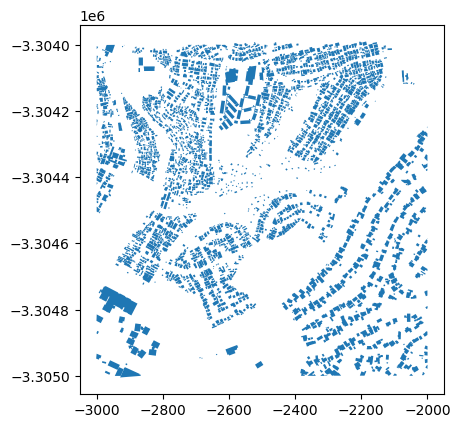

In [ ]:
mask_plot = gpd.read_file(shp_path)
mask_plot["geometry"].plot();

In [ ]:
print(f'Number of images: {len(images_list)}')
print(images_list[0])

Number of images: 1
/content/drive/MyDrive/BEAM/training_images/images/2020_RGB_10cm_CA_065.tif


Create Masks Corresponding to Selected Images

In [ ]:
images_list

(#1) [Path('/content/drive/MyDrive/BEAM/training_images/images/2020_RGB_10cm_CA_065.tif')]

In [ ]:
mask_plot.crs

<Projected CRS: PROJCS["GCS_HARTEBEESTHOEK_1994",GEOGCS["Hartebees ...>
Name: GCS_HARTEBEESTHOEK_1994
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Hartebeesthoek94
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
# Create masks corresponding to selected images
erode = True
save_masks(images_list, shp_path, path/f'untiled_masks_eroded/' if erode else path/f'untiled_masks/')

  0%|          | 0/1 [00:00<?, ?it/s]WARNING:rasterio._env:CPLE_AppDefined in The definition of geographic CRS EPSG:4148 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
<ipython-input-3-2b648c3e2f1b>:102: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)
100%|██████████| 1/1 [00:10<00:00, 10.77s/it]


Tile Selected Images and Corresponding Masks

In [ ]:
# Tile images and masks with a stride of 0 pixels
erode = True
tile_size = 256
tile_img_msk(images_list, tile_size, padding = 0)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1/1 [10:46<00:00, 646.99s/it]


Tile Only Selected Image(s)

In [ ]:
len(get_image_files(path/'image_tiles'))

1521

In [ ]:
path

Path('/content/drive/MyDrive/BEAM/training_imagery')

In [ ]:
len(get_image_files(path/'mask_tiles_erode'))

1521

In [ ]:
images = f'{path}/image_tiles'
masks = f'{path}/mask_tiles_erode'

# Use the shell command to zip the folders
!zip -r images_masks_ethekwini.zip {images} {masks}

# Copy the zip file to the destination folder
shutil.copy("images_masks_ethekwini.zip", path)

  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/ (stored 0%)
  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_0.png (deflated 0%)
  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_1.png (deflated 0%)
  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_3.png (deflated 0%)
  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_2.png (deflated 0%)
  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_4.png (deflated 0%)
  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_8.png (deflated 0%)
  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_5.png (deflated 0%)
  adding: content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_7.png (deflated 0%)
  adding: content/drive/MyDrive/BEAM/training_ima

'/content/drive/MyDrive/BEAM/training_imagery/images_masks_ethekwini.zip'

In [ ]:
get_image_files(path/'image_tiles')

(#400) [Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_0.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_1.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_2.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_3.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_4.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_5.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_6.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_7.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_8.png'),Path('/content/drive/MyDrive/BEAM/training_imagery/image_tiles/2020_RGB_10cm_CA_065_0_9.png')...]

In [ ]:
(3000/512)

5.859375

In [ ]:
tile_size = 500
output_path = path/"inference/input"
if not os.path.exists(str(output_path)):
  os.makedirs(str(output_path))

tile_img(images_list, output_path, tile_size, single = False)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1/1 [01:04<00:00, 64.27s/it]


In [ ]:
# Sanity check
print(len(get_image_files(output_path)))
print(len(images_list * 400))

400
400
